# IHS locus artwork

## Setup

In [1]:
%run locus-artwork-setup.ipynb

In [153]:
def plot_ihs_max_percentiles(pop, window_size=50, window_step=50):
    fig, ax = plt.subplots(facecolor='w', figsize=(9, 3))
    
    # plot each chromosome
    x = list(range(90, 100)) + [99.5, 99.9]
    all_vals = []
    for chromosome in '2', '3', 'X':
        # load gwss data
        _, _, ihs_max, _, _, _ = load_ihs_gwss(pop, chromosome, window_size=window_size, window_step=window_step)
        all_vals.append(ihs_max)
        # plot 
        y = [np.percentile(ihs_max, i) for i in x]
        ax.plot(x, y, marker='o', label=chromosome)
        
    # plot all
    ihs_max = np.concatenate(all_vals)
    y = [np.percentile(ihs_max, i) for i in x]
    ax.plot(x, y, marker='o', label='all', color='k', lw=2)

    # tidy
#     ax.set_ylim(bottom=0, top=0.4)
    ax.legend(loc='upper left', title='Chromosome')
    ax.set_xticks(x)
    ax.set_xlabel('Percentile')
    ax.set_ylabel('$|IHS|_{max}$')
    ax.set_title(pop_defs[pop]['label'])
    
    plt.show()
    plt.close()
    

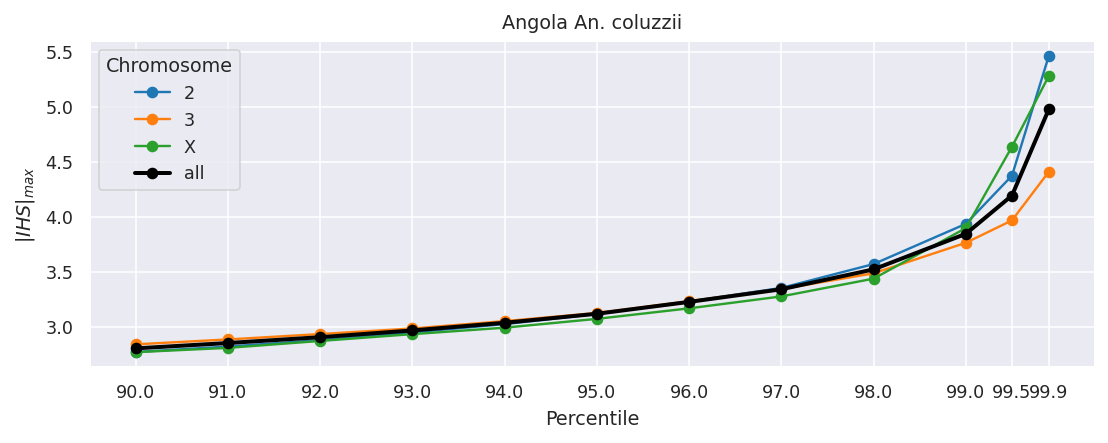

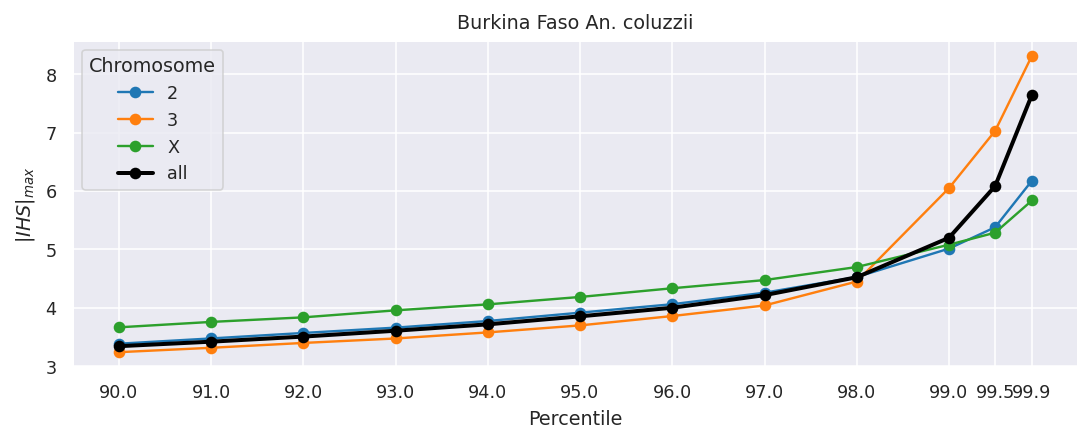

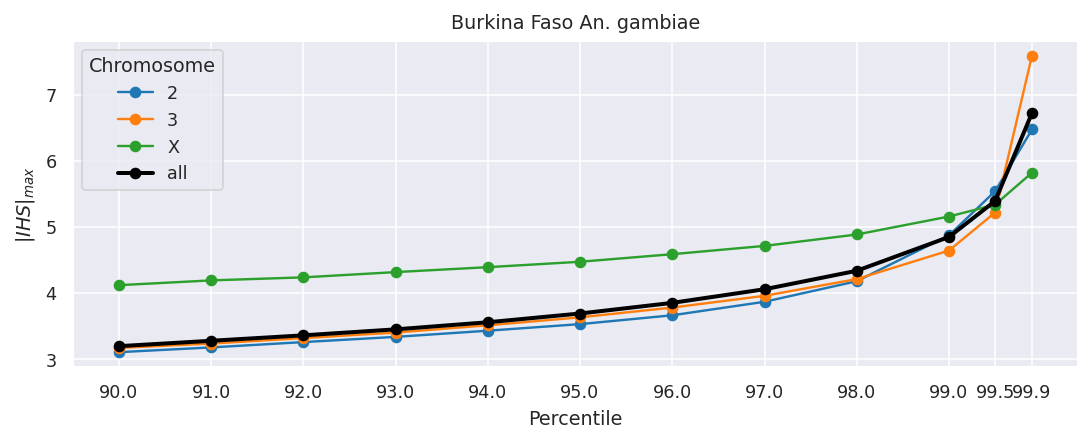

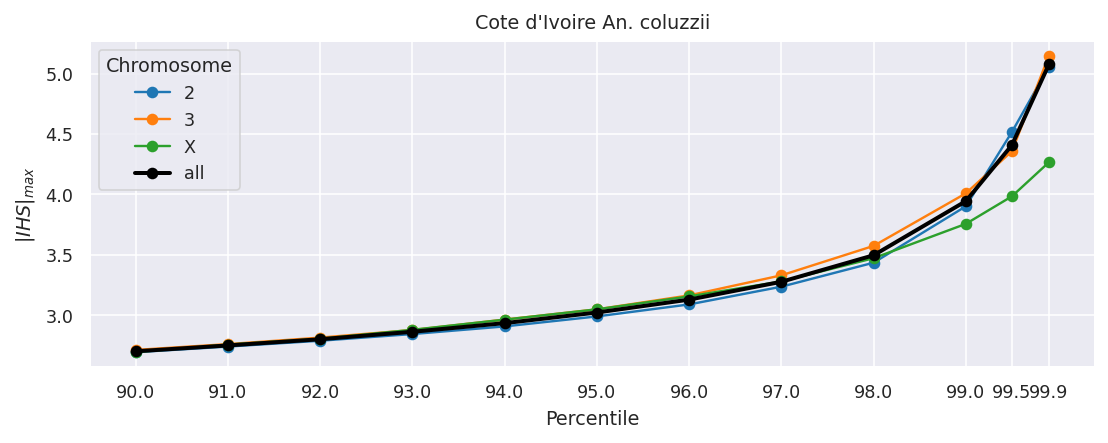

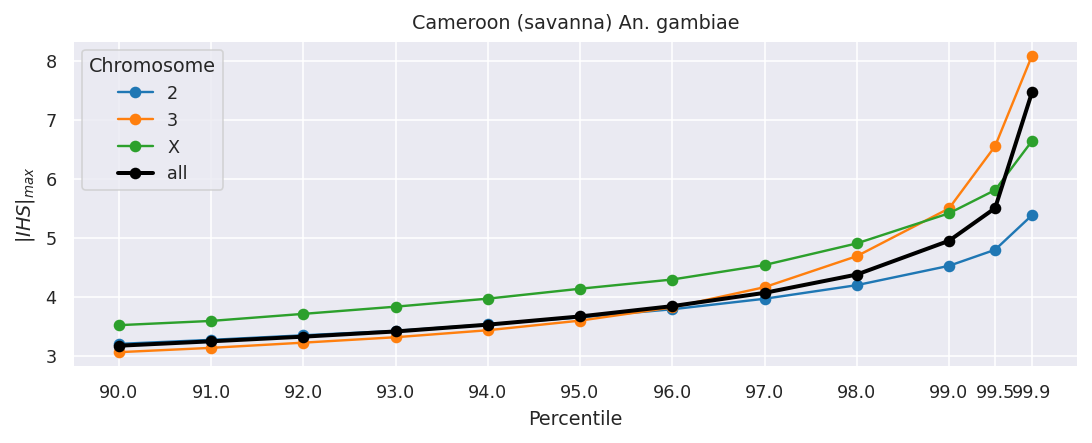

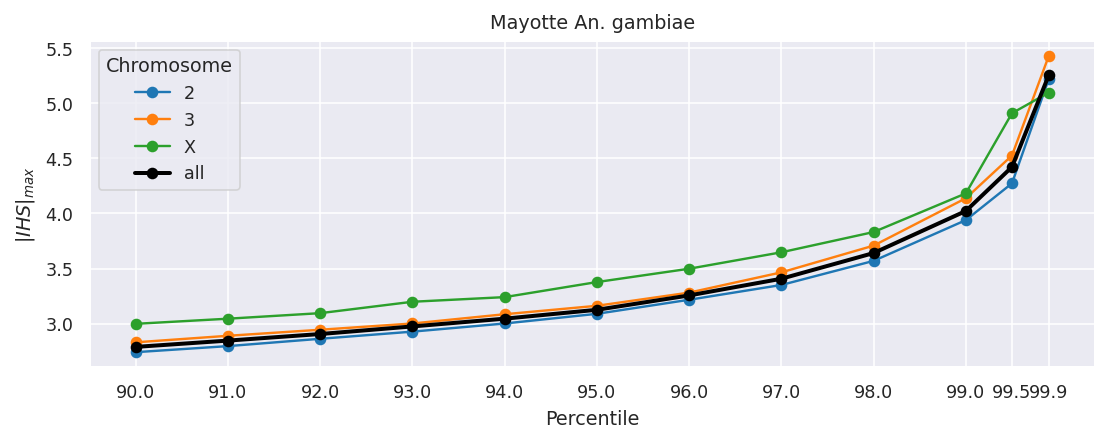

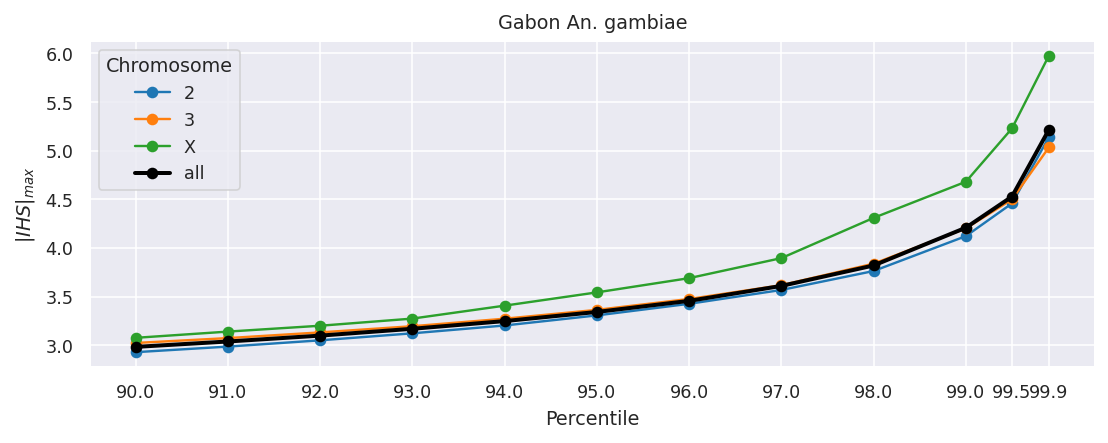

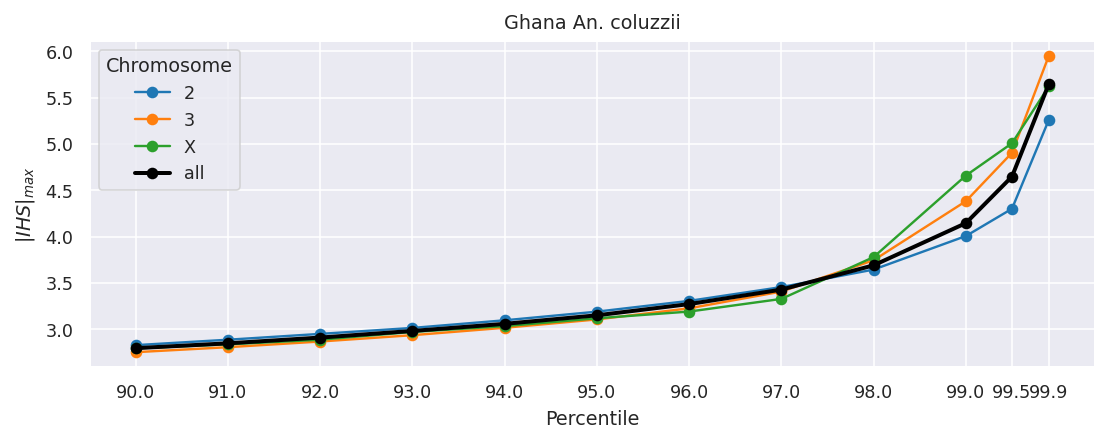

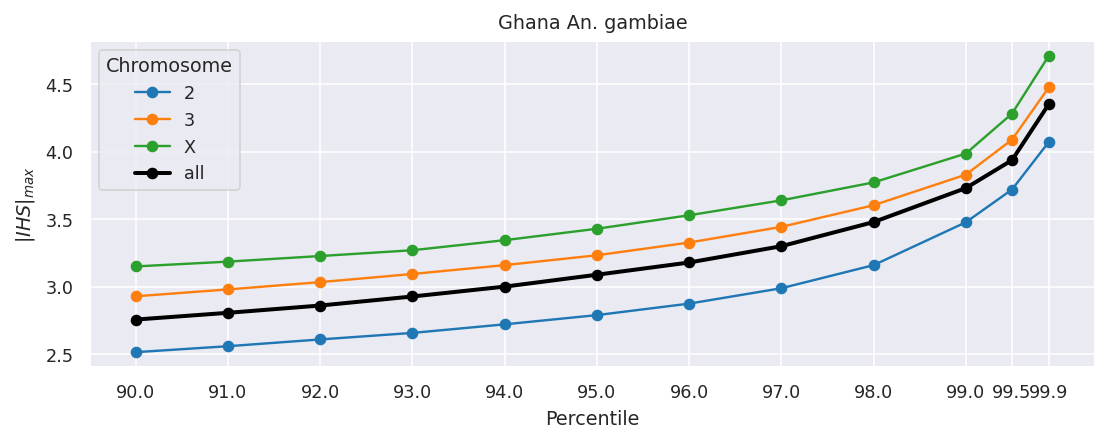

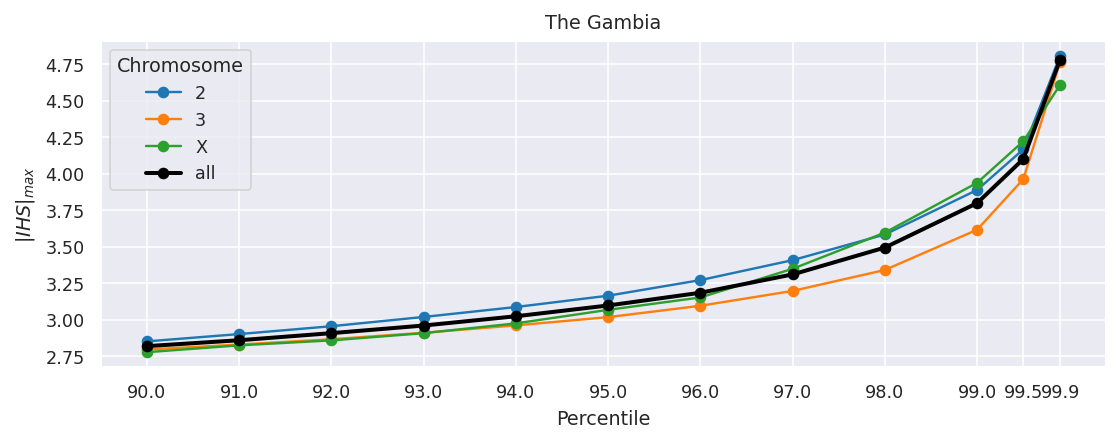

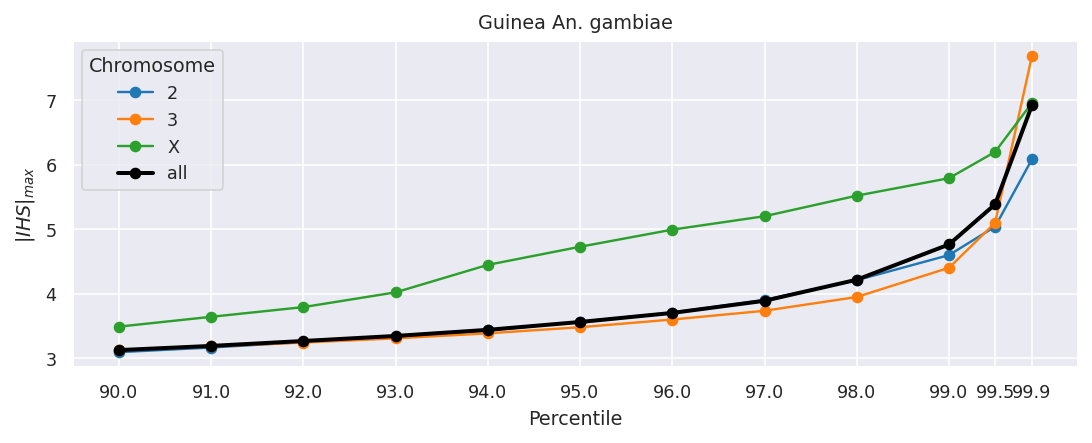

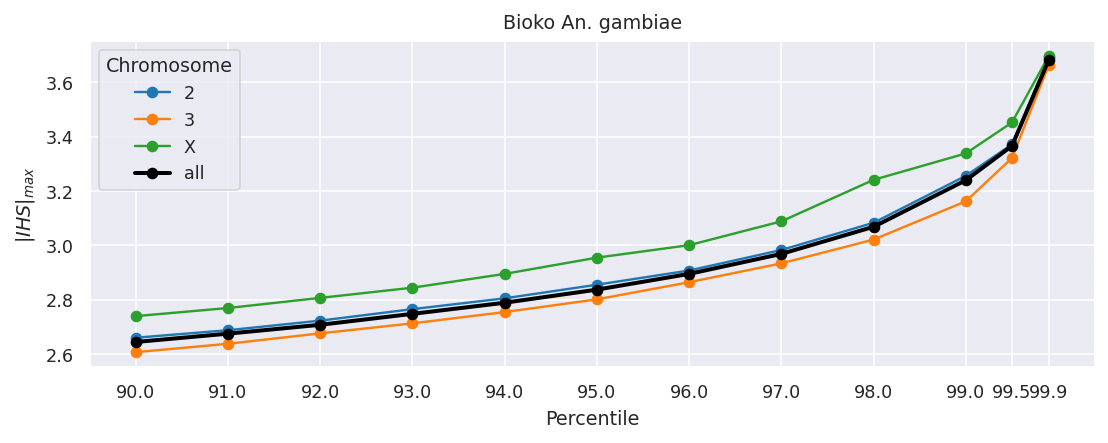

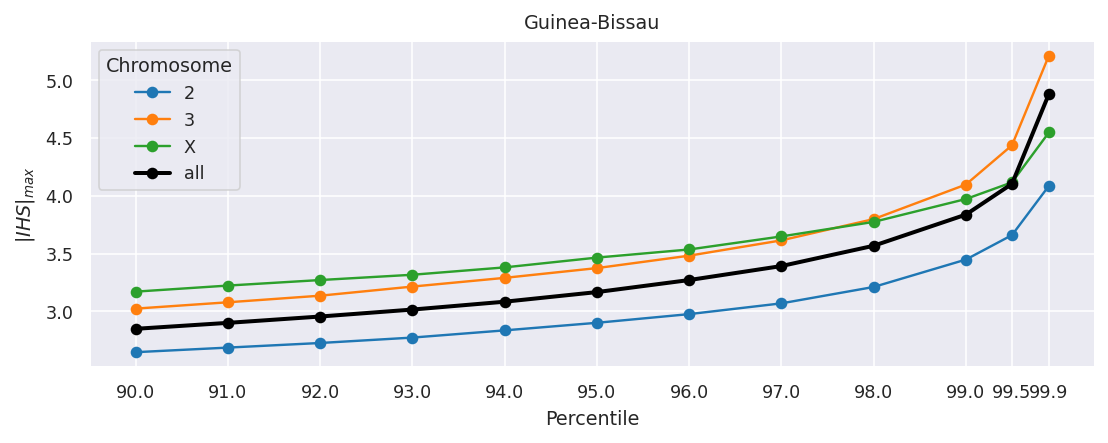

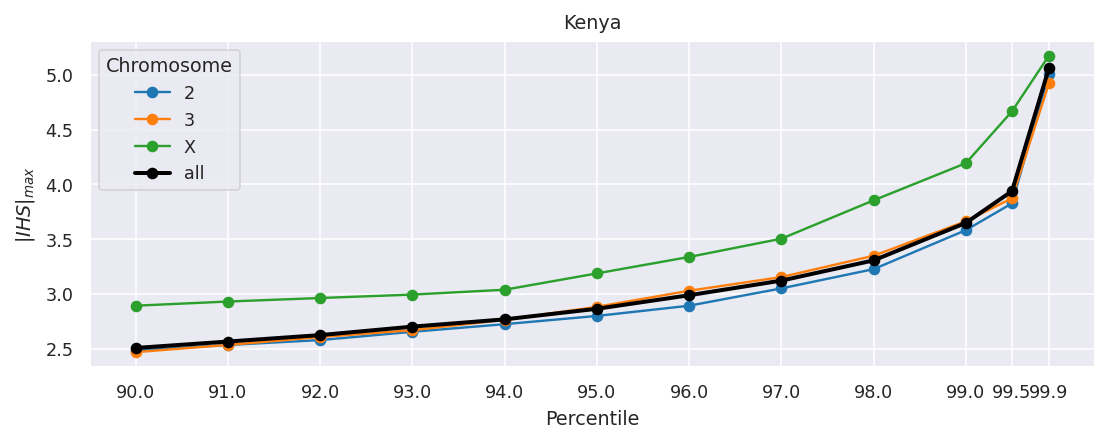

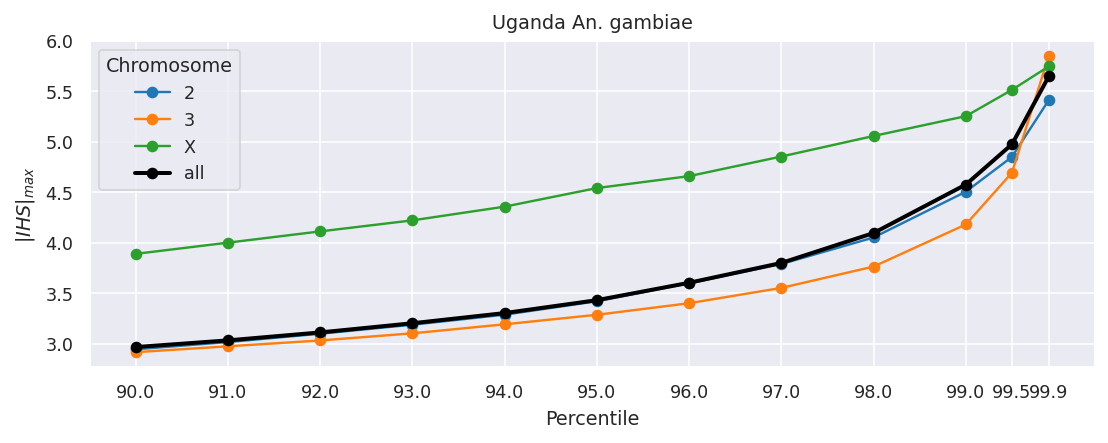

In [154]:
for pop in pop_defs:
    plot_ihs_max_percentiles(pop)

In [155]:
@functools.lru_cache(maxsize=None)
def get_ihs_max_percentile(pop, q, window_size, window_step):
    all_vals = []
    for chromosome in '2', '3', 'X':
        # load gwss data
        _, _, ihs_max, _, _, _ = load_ihs_gwss(pop, chromosome, window_size=window_size, window_step=window_step)
        all_vals.append(ihs_max)
    ihs_max = np.concatenate(all_vals)
    return np.percentile(ihs_max, q)
    

In [157]:
get_ihs_max_percentile('bf_gam', 99, window_size=50, window_step=50)

4.84588895871614

In [158]:
def plot_ihs(pop, chromosome, center, flank, ax=None, markersize=3, 
             window_size=50, window_step=50, step=2, shift=0, 
             legend=False, label=True, ymax=None, genetic_distance=False,
             percentiles=[98], detail=False, has_peak_windows=20):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 2), facecolor='w')
        
    # plot center line
    if genetic_distance:
        gcenter = mbp2cm(chromosome, center)
        ax.axvline(gcenter, color='w', linestyle='-', lw=4, zorder=0)
    else:
        ax.axvline(center, color='w', linestyle='-', lw=4, zorder=0)
        
    # figure out x limits
    if isinstance(flank, (int, float)):
        xlim = center - flank, center + flank
    elif isinstance(flank, tuple):
        xlim = center - flank[0], center + flank[1]
    else:
        raise ValueError

    # load gwss data
    p, gp, y_max, y_pc95, y_pc75, y_pc50 = load_ihs_gwss(pop, chromosome, 
                                                         window_size=window_size, 
                                                         window_step=window_step)
    p = p/1e6
    if genetic_distance:
        x = gp
        xlim = mbp2cm(chromosome, xlim[0]), mbp2cm(chromosome, xlim[1])
    else:
        x = p

    # plot percentiles
    qvals = []
    for q in percentiles:
        v = get_ihs_max_percentile(pop, q, window_size=window_size, 
                                   window_step=window_step)
        qvals.append(v)
        ax.axhline(v, color='k', linestyle='--', lw=.5)
        ax.annotate(f'$P_{{{q}}}$', xy=(xlim[1], v), xytext=(2, 0), xycoords='data', 
                    textcoords='offset points', ha='left', va='center', fontsize=8)
    
    # plot gwss data
    if detail:
        palette = sns.color_palette("Reds_d", 4)
        ax.plot(x[shift::step], y_pc50[shift::step], marker='o', linestyle=' ', 
                markersize=markersize, color=palette[3], label='$P_{50}$')
        ax.plot(x[shift::step], y_pc75[shift::step], marker='o', linestyle=' ', 
                markersize=markersize, color=palette[2], label='$P_{75}$')
        ax.plot(x[shift::step], y_pc95[shift::step], marker='o', linestyle=' ', 
                markersize=markersize, color=palette[1], label='$P_{95}$')
        ax.plot(x[shift::step], y_max[shift::step], marker='o', linestyle=' ', 
                markersize=markersize, color=palette[0], label='$P_{100}$')
    else:
        palette = sns.color_palette()
        ax.plot(x[shift::step], y_max[shift::step], marker='o', linestyle=' ', 
                markersize=markersize, color=palette[3])

    # tidy plot
    ax.set_xlim(*xlim)
    if not ymax:
        loc_xlim = allel.SortedIndex(x).locate_range(*xlim)
        ymax = max(1.1*max(qvals), 1.1*np.max(y_max[loc_xlim]))
    ax.set_ylim(0, ymax)
    ax.set_ylabel('$|IHS|$')
    if detail and legend:
        lgd = ax.legend(bbox_to_anchor=(1, 1), loc='upper right', facecolor='w', 
                        edgecolor='w')
        for handle in lgd.legendHandles:
            handle._legmarker.set_markersize(6)
            
    # statistics
    has_peak = False
    try:
        loc_peak_test = allel.SortedIndex(p).locate_range(center-.5, center+.5)
        has_peak = call_peak(y_max[loc_peak_test], qvals[-1], has_peak_windows)
    except KeyError:
        pass
    if has_peak:
        loc_region = allel.SortedIndex(p).locate_range(center-1, center+1)
        peak_value = np.max(y_max[loc_region])
        pos_peak = p[loc_region][np.argmax(y_max[loc_region])] - center
        statistics = dict(
            pop=pop,
            ihs_peak=peak_value,
            pos_ihs_peak=pos_peak
        )
    else:
        statistics = dict(
            pop=pop,
            ihs_peak=np.nan,
            pos_ihs_peak=np.nan,
        )
    
    if label:
        pop_label = (
            pop_defs[pop]['label']
            .replace("An. gambiae", "$An. gambiae$")
            .replace("An. coluzzii", "$An. coluzzii$")
        )
        if has_peak:
            annotation = (
                f"{pop_label}\n$"
                f"|IHS|_{{peak}}={peak_value:.1f}$\n"
                f"$pos(|IHS|_{{peak}})={pos_peak*1e3:+.1f}$ kbp"
            )
        else:
            annotation = pop_label
        ax.annotate(annotation, xy=(0, 1), xytext=(8, -8), 
                    xycoords='axes fraction', textcoords='offset points', 
                    fontsize=8, va='top', ha='left', backgroundcolor='white')
    
    return statistics


{'pop': 'bf_gam', 'ihs_peak': nan, 'pos_ihs_peak': nan}

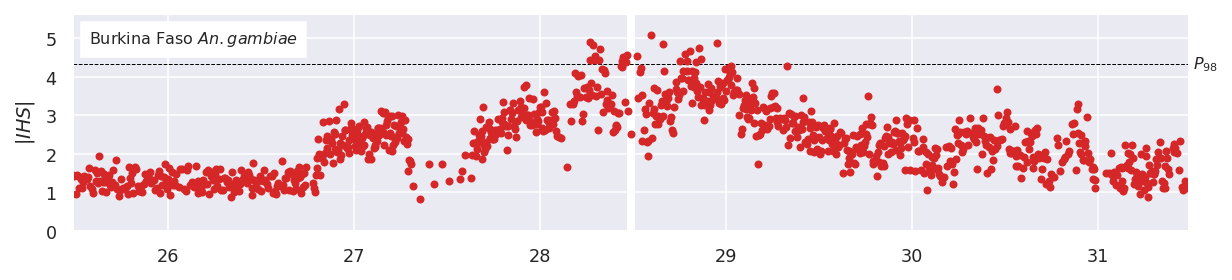

In [159]:
plot_ihs('bf_gam', cyp6p3.chromosome, cyp6p3.chromosome_center/1e6, flank=3, legend=True)

{'pop': 'bf_gam', 'ihs_peak': nan, 'pos_ihs_peak': nan}

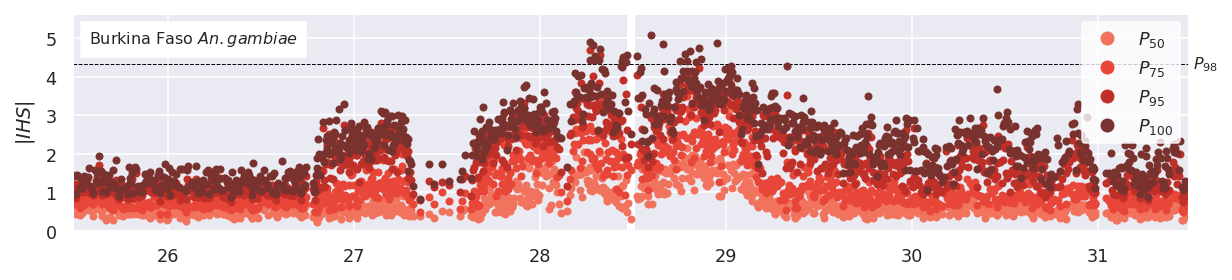

In [160]:
plot_ihs('bf_gam', cyp6p3.chromosome, cyp6p3.chromosome_center/1e6, flank=3, 
         legend=True, detail=True)

{'pop': 'gn_gam',
 'ihs_peak': 5.579563993087699,
 'pos_ihs_peak': 0.27740890000000107}

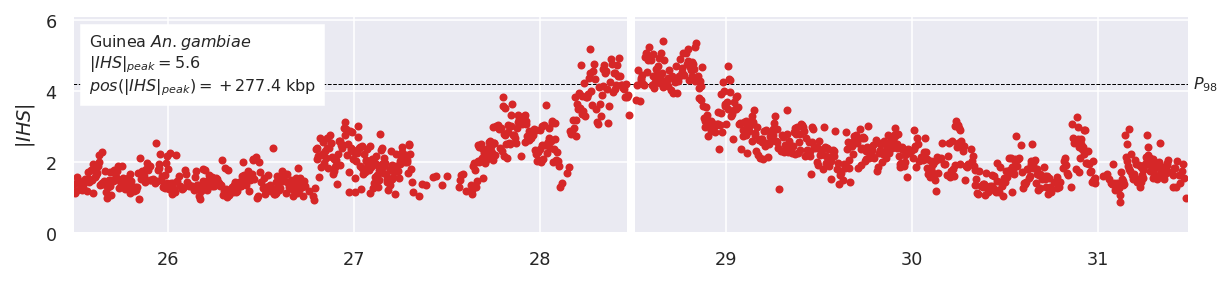

In [161]:
plot_ihs('gn_gam', cyp6p3.chromosome, cyp6p3.chromosome_center/1e6, flank=3)

{'pop': 'bf_col', 'ihs_peak': nan, 'pos_ihs_peak': nan}

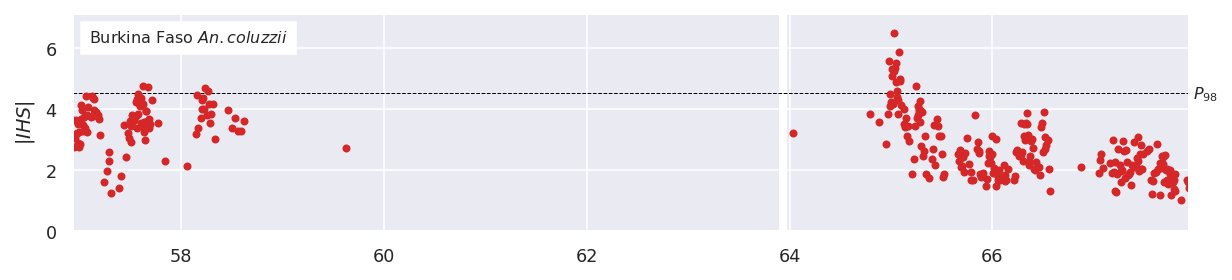

In [162]:
plot_ihs('bf_col', vgsc.chromosome, vgsc.chromosome_center/1e6, 
         flank=(7, 4))

{'pop': 'bf_col', 'ihs_peak': nan, 'pos_ihs_peak': nan}

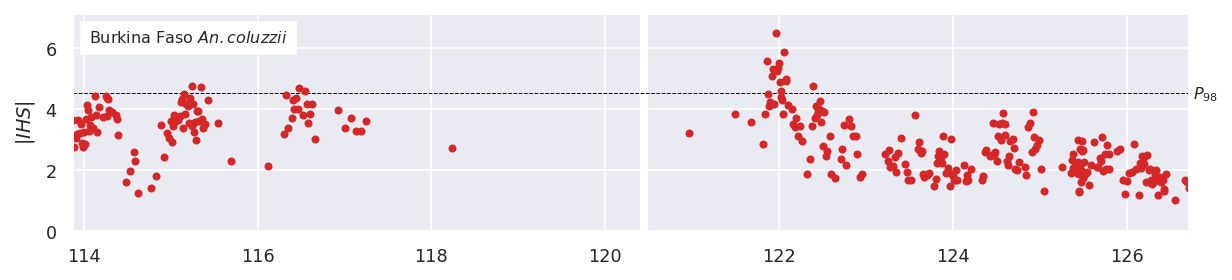

In [163]:
plot_ihs('bf_col', vgsc.chromosome, vgsc.chromosome_center/1e6, 
         flank=(7, 4), genetic_distance=True)

## *Gste2*

In [164]:
gste2

seqid                            3R
source                   VectorBase
type                           gene
start                      28597652
end                        28598640
score                            -1
strand                            -
phase                            -1
Name                          Gste2
biotype              protein_coding
chromosome                        3
chromosome_start           28597652
chromosome_end             28598640
chromosome_center       2.85981e+07
Name: AGAP009194, dtype: object

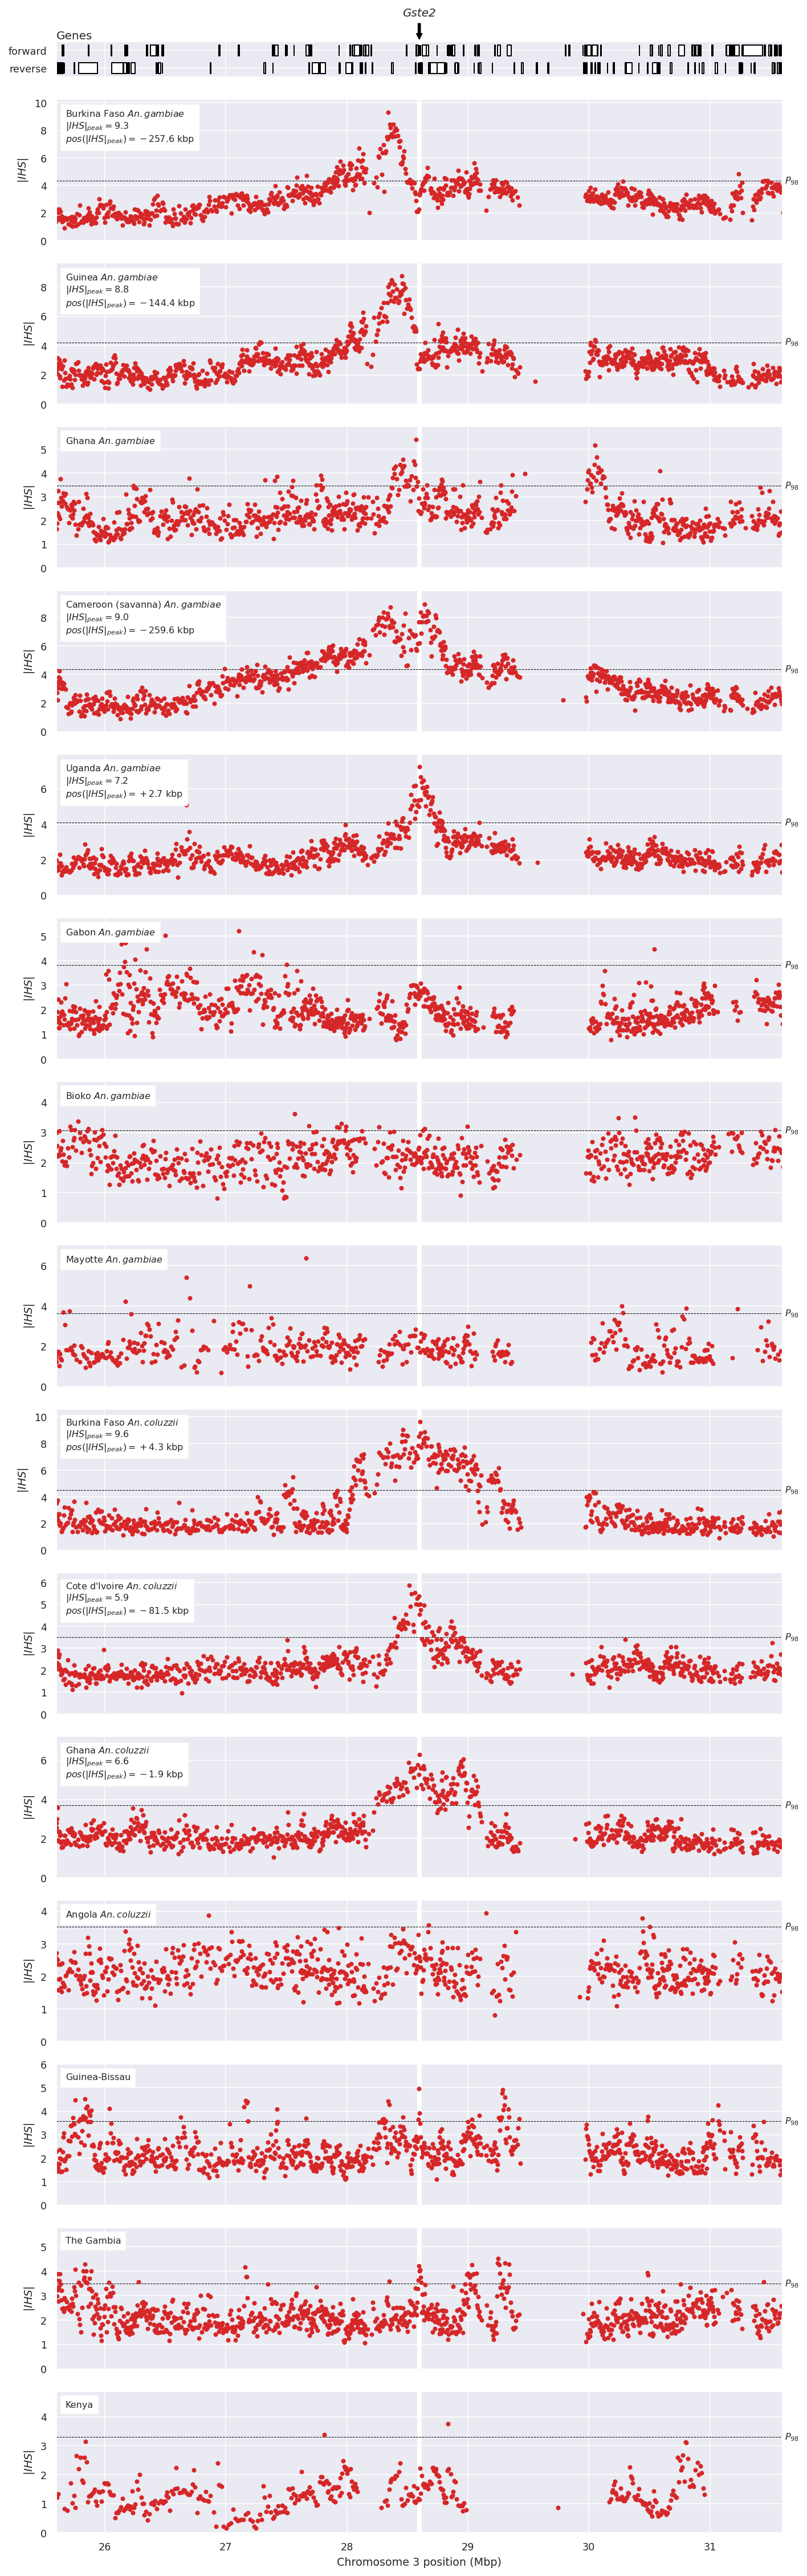

In [165]:
df_stats_gste2 = fig_locus(
    chromosome=gste2.chromosome, center=gste2.chromosome_center/1e6, 
    flank=3, label=gste2['Name'], track_height=2,
    tracks=(
        (plot_ihs, dict(pop='bf_gam')),
        (plot_ihs, dict(pop='gn_gam')),
        (plot_ihs, dict(pop='gh_gam')),
        (plot_ihs, dict(pop='cm_sav_gam')),
        (plot_ihs, dict(pop='ug_gam')),
        (plot_ihs, dict(pop='ga_gam')),
        (plot_ihs, dict(pop='gq_gam')),
        (plot_ihs, dict(pop='fr_gam')),
        (plot_ihs, dict(pop='bf_col')),
        (plot_ihs, dict(pop='ci_col')),
        (plot_ihs, dict(pop='gh_col')),
        (plot_ihs, dict(pop='ao_col')),
        (plot_ihs, dict(pop='gw')),
        (plot_ihs, dict(pop='gm')),
        (plot_ihs, dict(pop='ke')),
    ),
)

In [166]:
df_stats_gste2

,pop,ihs_peak,pos_ihs_peak,locus
0,bf_gam,9.332232,-0.257586,Gste2
1,gn_gam,8.752685,-0.144414,Gste2
2,gh_gam,NaN,NaN,Gste2
3,cm_sav_gam,8.995221,-0.259643,Gste2
4,ug_gam,7.231017,0.002744,Gste2
5,ga_gam,NaN,NaN,Gste2
6,gq_gam,NaN,NaN,Gste2
7,fr_gam,NaN,NaN,Gste2
8,bf_col,9.626270,0.004284,Gste2
9,ci_col,5.860608,-0.081457,Gste2


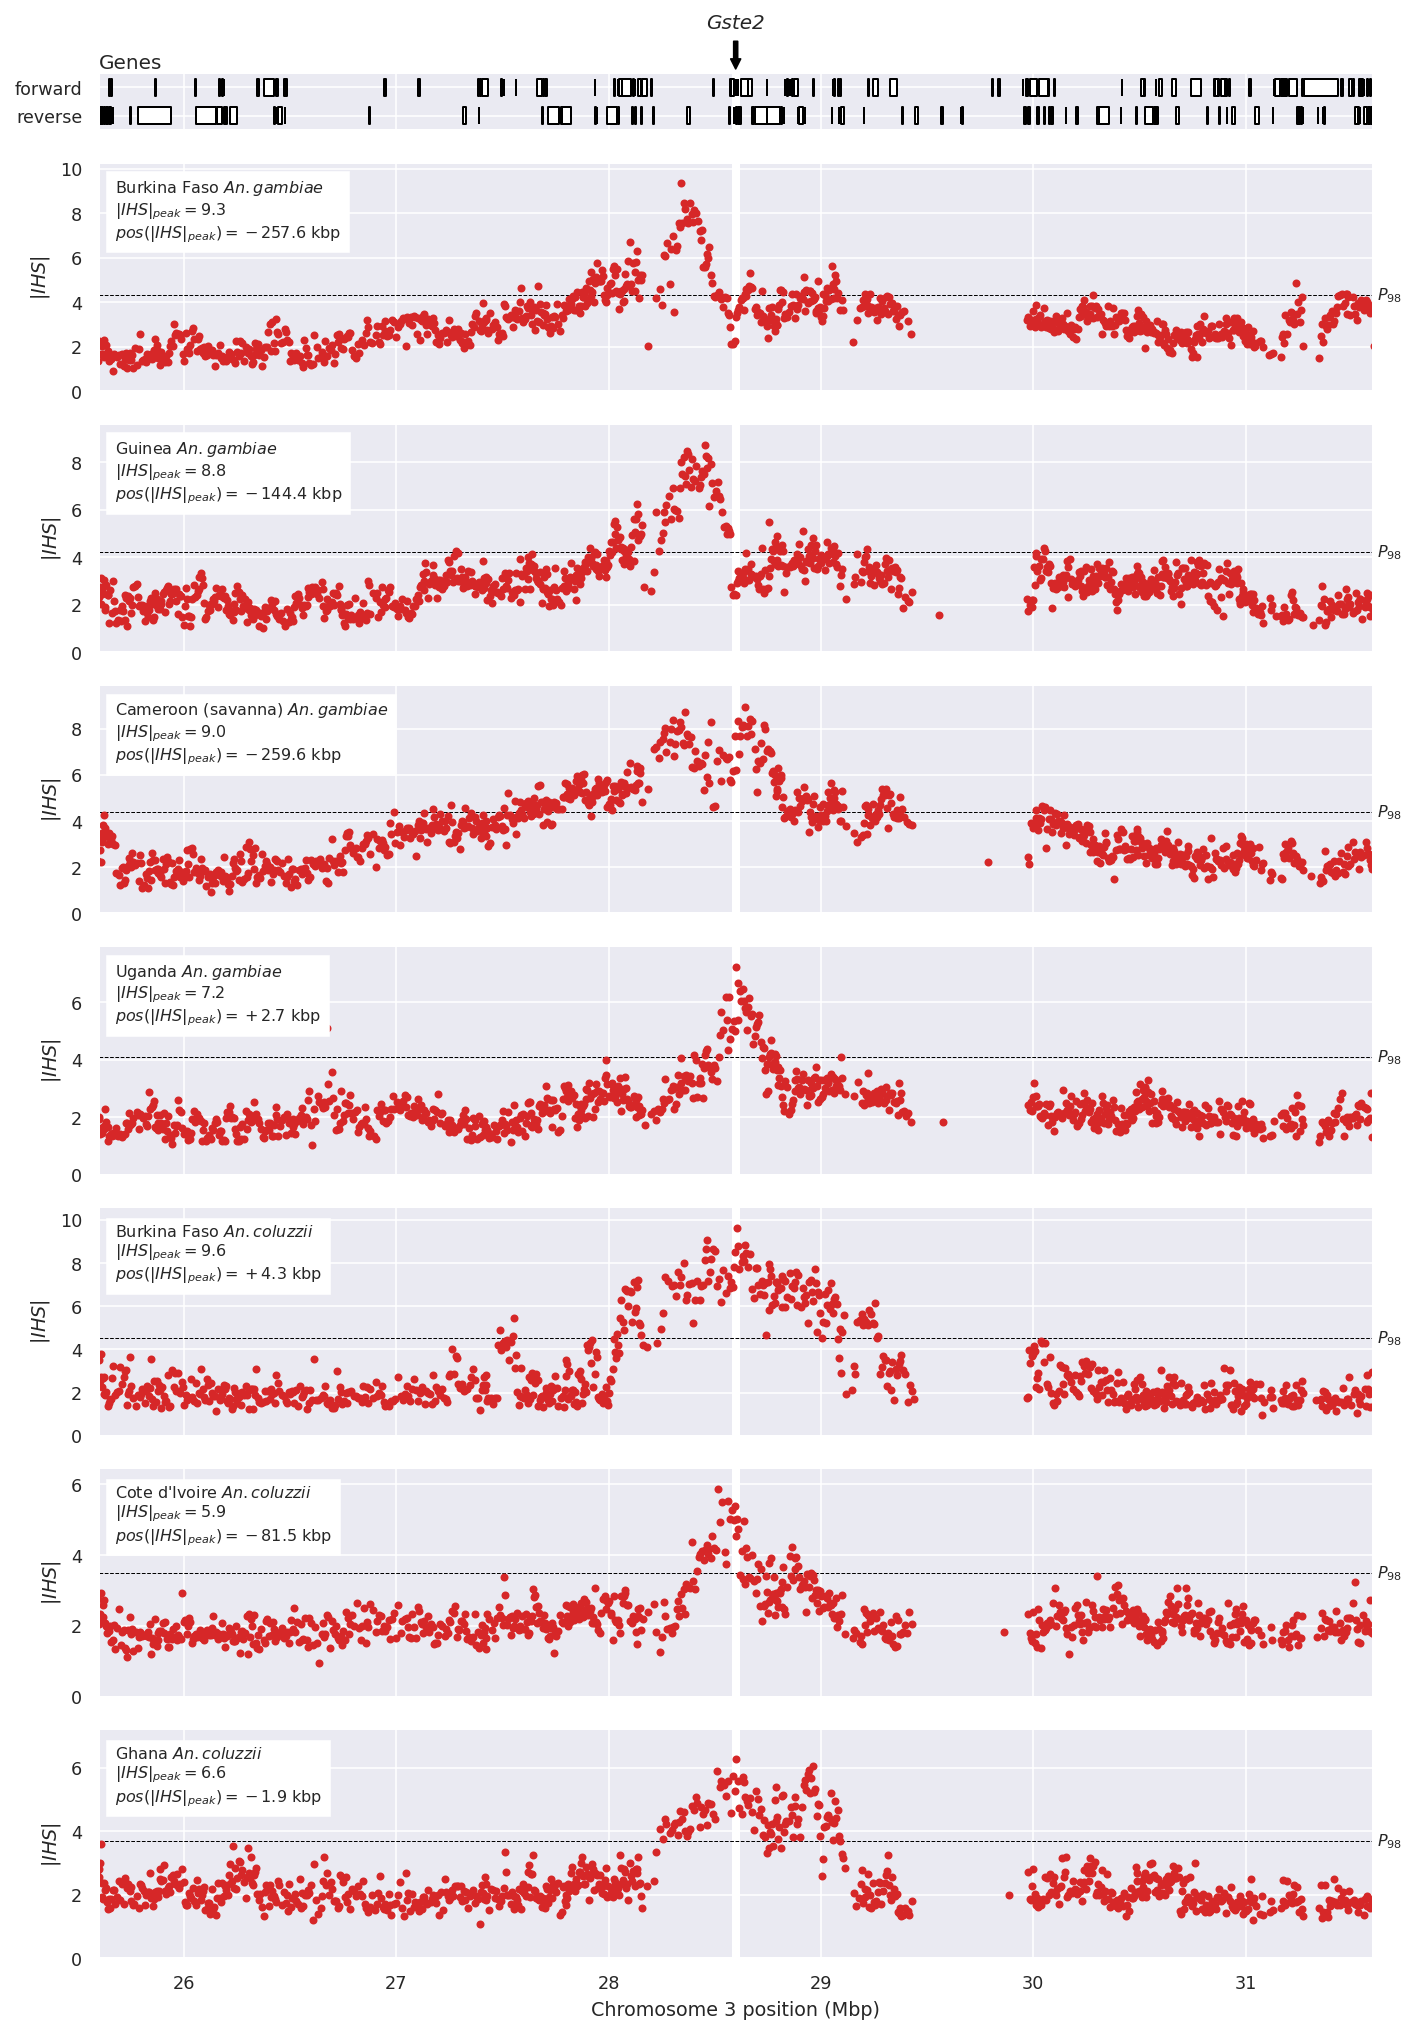

In [167]:
fig_locus(
    chromosome=gste2.chromosome, center=gste2.chromosome_center/1e6, 
    flank=3, label=gste2['Name'],
    tracks=(
        (plot_ihs, dict(pop='bf_gam')),
        (plot_ihs, dict(pop='gn_gam')),
#         (plot_ihs, dict(pop='gh_gam')),
        (plot_ihs, dict(pop='cm_sav_gam')),
        (plot_ihs, dict(pop='ug_gam')),
#         (plot_ihs, dict(pop='ga_gam')),
#         (plot_ihs, dict(pop='gq_gam')),
#         (plot_ihs, dict(pop='fr_gam')),
        (plot_ihs, dict(pop='bf_col')),
        (plot_ihs, dict(pop='ci_col')),
        (plot_ihs, dict(pop='gh_col')),
#         (plot_ihs, dict(pop='ao_col')),
#         (plot_ihs, dict(pop='gw')),
#         (plot_ihs, dict(pop='gm')),
#         (plot_ihs, dict(pop='ke')),
    ),
    savefig=here() / 'artwork/locus_gste2_ihs.png'
);